## Import Library

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import statsmodels.formula.api as smf

## Read Data dan Tampilan Awal
1. Ada 56 taman
1. Terdapat observasi yang variabelnya tergeser 1 ke kanan (karena common names)

In [2]:
sp1 = pd.read_csv("/kaggle/input/park-biodiversity/species.csv")
pa1 = pd.read_csv("/kaggle/input/park-biodiversity/parks.csv")

display(sp1.head(), pa1.head())
sp1["Park Name"].nunique()

/tmp/ipykernel_20/865988758.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  sp1 = pd.read_csv("/kaggle/input/park-biodiversity/species.csv")


,Species ID,Park Name,Category,Order,Family,Scientific Name,Common Names,Record Status,Occurrence,Nativeness,Abundance,Seasonality,Conservation Status,Unnamed: 13
0,ACAD-1000,Acadia National Park,Mammal,Artiodactyla,Cervidae,Alces alces,Moose,Approved,Present,Native,Rare,Resident,NaN,NaN
1,ACAD-1001,Acadia National Park,Mammal,Artiodactyla,Cervidae,Odocoileus virginianus,"Northern White-Tailed Deer, Virginia Deer, Whi...",Approved,Present,Native,Abundant,NaN,NaN,NaN
2,ACAD-1002,Acadia National Park,Mammal,Carnivora,Canidae,Canis latrans,"Coyote, Eastern Coyote",Approved,Present,Not Native,Common,NaN,Species of Concern,NaN
3,ACAD-1003,Acadia National Park,Mammal,Carnivora,Canidae,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",Approved,Not Confirmed,Native,NaN,NaN,Endangered,NaN
4,ACAD-1004,Acadia National Park,Mammal,Carnivora,Canidae,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Re...",Approved,Present,Unknown,Common,Breeder,NaN,NaN


,Park Code,Park Name,State,Acres,Latitude,Longitude
0,ACAD,Acadia National Park,ME,47390,44.35,-68.21
1,ARCH,Arches National Park,UT,76519,38.68,-109.57
2,BADL,Badlands National Park,SD,242756,43.75,-102.50
3,BIBE,Big Bend National Park,TX,801163,29.25,-103.25
4,BISC,Biscayne National Park,FL,172924,25.65,-80.08


56

## Preprocessing Data
1. Kita benahi observasi dengan variabel tergeser ke kanan
    1. Observasi normal kita hapus kolom index 13
    1. Observasi tergeser, kita geser ke kiri, dan hapus kolom index 13
    1. Kita gabungkan keduanya.
1. Untuk spesies dengan duplikat, kita hapus, dan pertahankan data terbaru
1. Dibuat variabel baru, Count, dengan kemunculan Present -> 1, sisanya dijadikan 0
1. Dilakukan persiapan untuk menghitung modified shannon index, dengan menggunakan bobot 10^x
1. Plot missing value

/tmp/ipykernel_20/2559179014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp2b.loc[:, sp2b.columns[7:-1]]  = np.array(sp2b.loc[:, sp2b.columns[8:]])


(119248, 13)

(119093, 13)

Species of Concern     3844
Endangered              374
Under Review            194
Threatened              185
In Recovery              77
Proposed Endangered      24
Proposed Threatened       7
Extinct                   1
Name: Conservation Status, dtype: int64

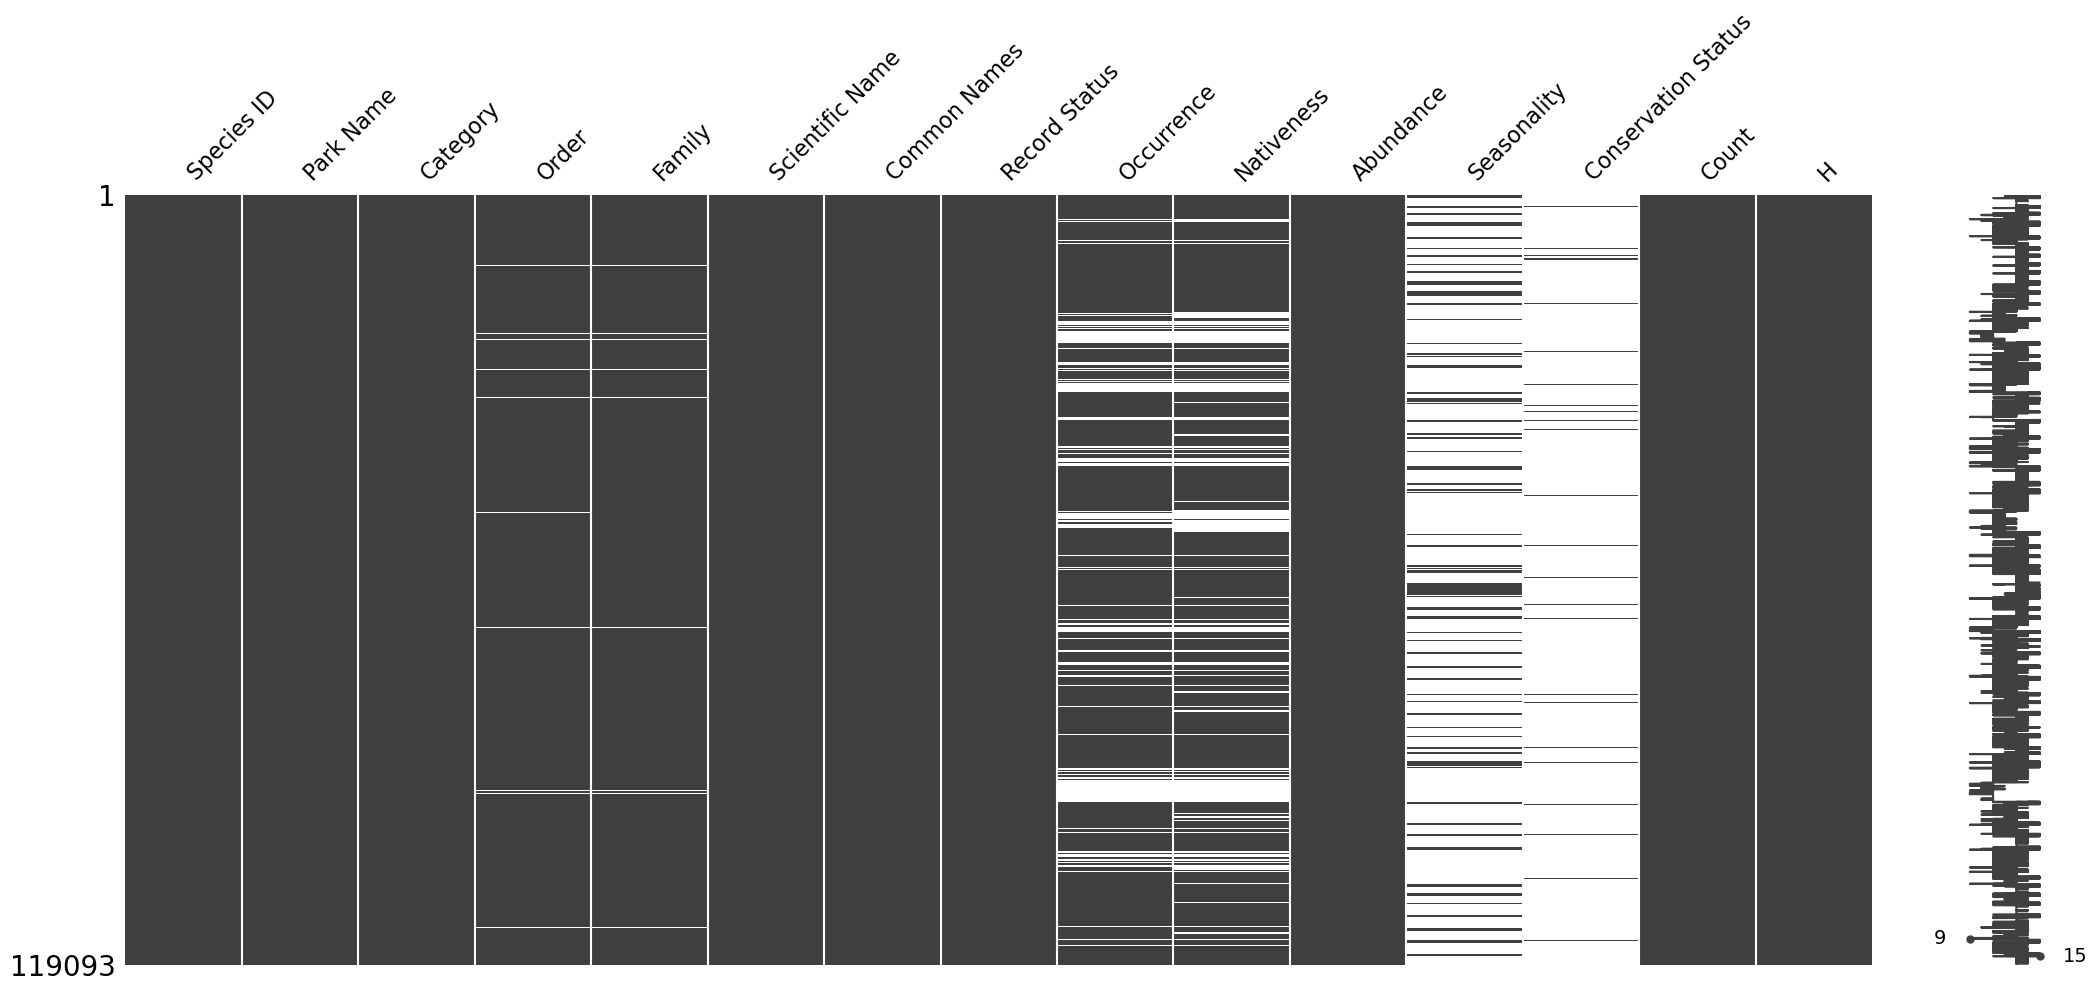

In [3]:
# 1. Variabel tergeser
mm = sp1["Record Status"].isin(sp1["Record Status"].value_counts().index[3:])

# non misplaced column
sp2a = sp1.loc[-mm,].drop(columns="Unnamed: 13")

# misplaced column
sp2b = sp1.loc[mm, ]
sp2b.loc[:, sp2b.columns[7:-1]]  = np.array(sp2b.loc[:, sp2b.columns[8:]])
sp2b = sp2b.drop(columns="Unnamed: 13")

sp2 = pd.concat([sp2a, sp2b])
sp2.sort_index(inplace=True)
display(sp2.shape)

# 2. Drop duplicate
sp2 = sp2[-sp2[["Park Name", "Scientific Name"]].duplicated(keep="last")]
display(sp2.shape)

# 3. Count
sp2["Count"] = 0
sp2.loc[sp2.Occurrence.isin(["Present"]), "Count"] = 1

# 4. Modified Shannon Index (H)
sp2.Abundance.fillna("Unknown", inplace=True)
sp2.Abundance.value_counts().index

sp2["AbWeight"] = sp2["Abundance"].replace(sp2["Abundance"].value_counts().index, [1,100,1000,10,10000,100000])
sp2["AbCount"] = sp2["AbWeight"]*sp2["Count"]
sp2["AbPercent"] = sp2["AbCount"]/sp2.groupby(["Park Name", "Category"])["AbCount"].transform("sum")
sp2["AbPercent"].fillna(0, inplace=True)
sp2["H"] = sp2["AbPercent"].transform(lambda x: np.where(x>0, -x*np.log2(x), 0))

sp2.drop(columns="AbWeight AbCount AbPercent".split(" "), inplace=True)

# 5. Missing value
msno.matrix(sp2)
sp2["Conservation Status"].value_counts()


### Biodiversity Index
1. Speciess Richness (Count) untuk tiap park untuk seluruh category
1. Modified H (H) untuk tiap park dan tiap category
1. Variabel baru akar kuadrat area atau perimeter (SqAcres) dan Species Density (Density) 


In [4]:
# 1. Species Richness
sp3a = sp2.groupby("Park Name")["Count"].sum().reset_index()

# 2. Modified Shannon-Wiener Index (Modified-H)
sp3b = sp2.groupby(["Park Name", "Category"])["H"].sum().reset_index()
sp3b = pd.pivot(sp3b, index="Park Name", columns="Category", values="H").reset_index()
df1a = pd.merge(pa1, sp3a, on="Park Name")
df1 = pd.merge(df1a, sp3b, on="Park Name")
df1 = df1.fillna(value=0)

# 3. Akar kuadrat area dan Species Density
df1["SqAcres"] = (df1.Acres)**0.5
df1["Density"] = df1["Count"]/df1["Acres"]


## Heatmap Modified Shannon Index

<Axes: xlabel='Park Code'>

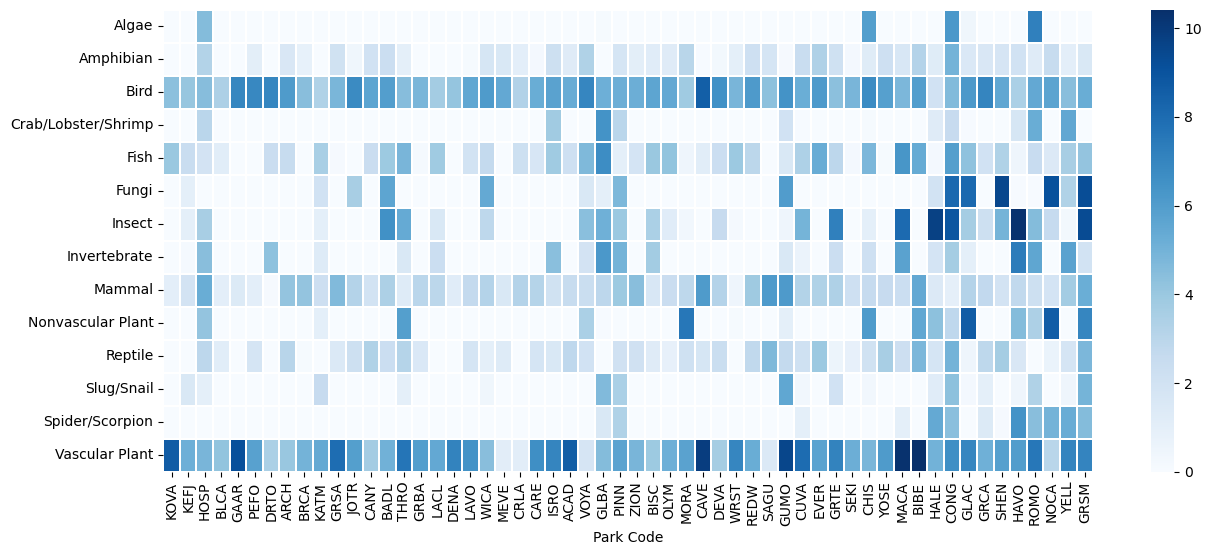

In [5]:
# sort by latitude or acres.
plt.figure(figsize=(15, 6))
sns.heatmap(df1.set_index("Park Code").sort_values("Count").iloc[:, 6:20].transpose(), 
            cmap=sns.color_palette("Blues", as_cmap=True), linecolor="white", linewidths=0.01)


## Scatterplot
1. Species Richness vs (Sq)Acres, dengan hue berupa latitude
1. Species Richness vs Acres, dengan hue berupa longitude

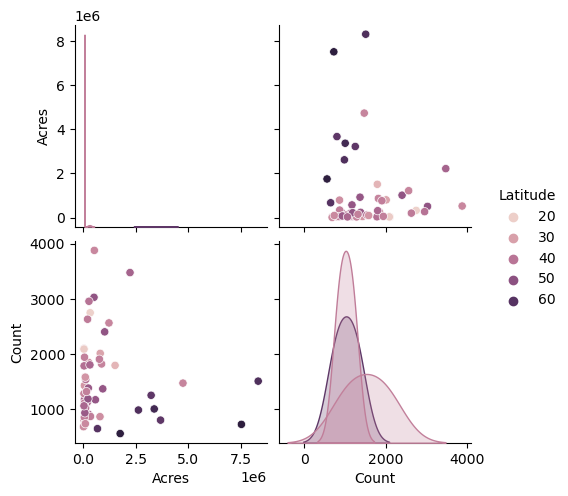

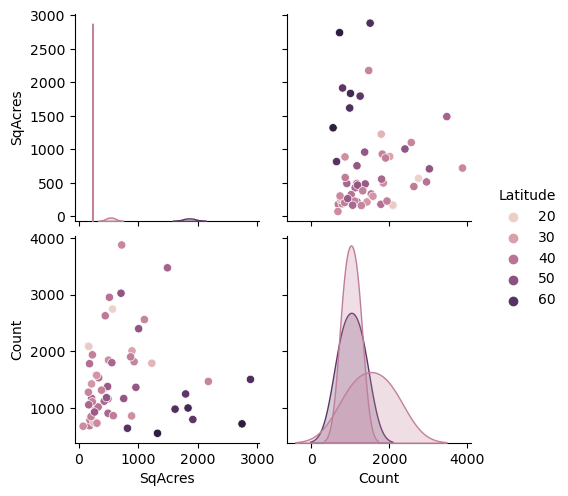

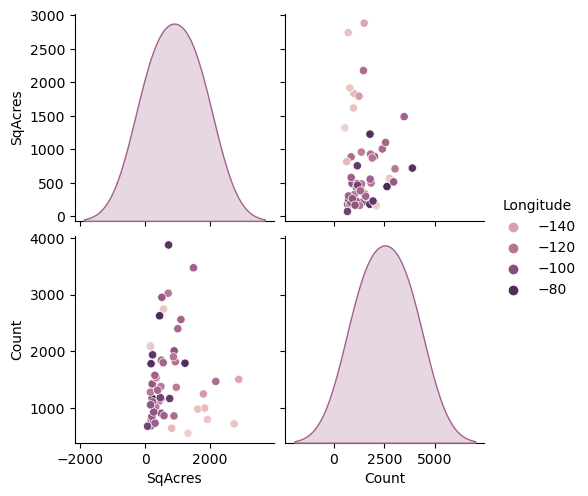

In [6]:
# 1. Count vs (Sq) Acres given latitude
sns.pairplot(df1[["Acres", "Latitude", "Count"]], hue="Latitude")
sns.pairplot(df1[["SqAcres", "Latitude", "Count"]], hue="Latitude")

# 2. Count vs SqAcres given Longitude
sns.pairplot(df1[["SqAcres", "Longitude", "Count"]], hue="Longitude")

### An Extras
Linear regression with interaction; **LogCount ~ Latitude + SqAcres + SqAcres:Latitude**

In [7]:
# extras, modelling
df2 = df1.copy()
df2["LogCount"] = np.log(df2["Count"])

mod1 = smf.ols(formula='LogCount ~ Latitude + SqAcres + SqAcres:Latitude', data=df2).fit()
summ1 = mod1.summary()
summ1.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.3559,0.405,18.178,0.000,6.544,8.168
Latitude,-0.0087,0.010,-0.867,0.390,-0.029,0.011
SqAcres,0.0010,0.000,2.415,0.019,0.000,0.002
SqAcres:Latitude,-1.455e-05,7.72e-06,-1.885,0.065,-3e-05,9.4e-07


## Map Function

In [8]:
def fMap(cat="Count", area = "SqAcres"):    
    color_scale = [(0, 'silver'), (1,'red')]

    fig = px.scatter_mapbox(df1, 
                            lat="Latitude", 
                            lon="Longitude", 
                            hover_name="Park Name", 
                            hover_data=["Park Name", cat , area],
                            color=cat,
                            color_continuous_scale=color_scale,
                            size=area,
                            zoom=1.5, 
                            height=500,
                            width=600)

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

## Species Richness Map
1. Color based on Species Richness and Size based on Acres
1. Color based on Species Richness and Size based on SqAcres
1. Color and Size based on Species Density

In [9]:
fMap("Count", "Acres")
fMap("Count", )
fMap("Density", "Density")

### Modified Shannon Index (H) for Each Category
Color based on H, meanwhile size based on SqAcres   
**vascular plant, bird, fish, mammal, reptile, dan amphibian**

In [10]:
fMap("Vascular Plant")
fMap("Bird")
fMap("Fish")
fMap("Mammal")
fMap("Reptile")
fMap("Amphibian")

### Modified Shannon Index (H) for Each Category

Color based on H, meanwhile size based on SqAcres   
**spider, crab, invertebrate, snail**


In [11]:
fMap("Spider/Scorpion")
fMap('Crab/Lobster/Shrimp')
fMap("Invertebrate")
fMap("Slug/Snail")

### Modified Shannon Index (H) for Each Category
Color based on H, meanwhile size based on SqAcres   
**algae, insect, fungi, nonvascular plant**

In [12]:
fMap("Algae")
fMap("Fungi")
fMap("Insect")
fMap("Nonvascular Plant")


### Then, we can focus on the endagered/concern species.
Masuk ke extras sih, kalau mau.